# Name: Rishabh Singhal

# Roll No. : 16NA10019

In [1]:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torchvision.datasets as datasets
    import torchvision.transforms as transforms
    from torch.autograd import Variable
    import os
    import math
    import torch.optim as optim
    from IPython import display
    import itertools
    import matplotlib.pyplot as plt

In [2]:
#Dataloader

transform = transforms.Compose([transforms.Resize(28),transforms.ToTensor()])
BatchSize = 100
trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize, shuffle=True)
testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)
testloader= torch.utils.data.DataLoader(testset, batch_size=BatchSize, shuffle=True)


In [3]:
print(len(trainloader))

600


In [4]:
def to_np(x):
    return x.data.cpu().numpy()
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)
def to_cuda(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return x

In [5]:
class Q_net(nn.Module):
    def __init__(self,X_dim,N,z_dim):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N,100)
        self.lin3gauss = nn.Linear(100, z_dim)
    def forward(self,x):
        x=F.dropout(self.lin1(x), p=0.35, training= self.training)
        x=F.relu(x)
        x=F.dropout(self.lin2(x), p=0.25, training= self.training)
        x=F.relu(x) 
        xgauss=self.lin3gauss(x)
        return xgauss

In [6]:
#Decoder Model

class P_net(nn.Module):
    def __init__(self,X_dim,N,z_dim):
        super(P_net,self).__init__()
        self.lin1 = nn.Linear(z_dim , 100)
        self.lin2 = nn.Linear(100, N)
        self.lin3 = nn.Linear(N, X_dim)
    def forward(self, x):
        x= F.dropout(self.lin1(x), p= 0.30, training= self.training)
        x= F.relu(x)
        x= F.dropout(self.lin2(x), p= 0.45, training= self.training)
        x= self.lin3(x)
        return F.sigmoid(x)

In [7]:
#Discriminator Model
class D_net_gauss(nn.Module):
    def __init__(self, N, z_dim):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, 10)
        self.lin2 = nn.Linear(10, N)
        self.lin3 = nn.Linear(N, 2)
    def forward(self, x):
 #       x=self.l1(x)
        x=  F.dropout(self.lin1(x), p= 0.15, training= self.training)
        x= F.relu(x)
 #       x=self.l2(x)
        x=  F.dropout(self.lin2(x), p= 0.2, training= self.training)
        x= F.relu(x)
        return F.sigmoid(self.lin3(x))
        

In [8]:
#Network

#z_red_dims = 2
Q = to_cuda(Q_net(28*28, 400, 2))
P = to_cuda(P_net(28*28, 400, 2))
D_gauss =to_cuda(D_net_gauss(10,2))

gen_lr = 0.001
reg_lr = 0.0006

#Optimiser
optim_P = optim.Adam(P.parameters(), lr = gen_lr)
optim_Q_enc = optim.Adam(Q.parameters(), lr = gen_lr)
optim_Q_gen = optim.Adam(Q.parameters(), lr = reg_lr)
optim_D= optim.Adam(D_gauss.parameters(),lr = reg_lr)

In [9]:
print(P)
print(Q)
print(D_gauss)

P_net(
  (lin1): Linear(in_features=2, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=400, bias=True)
  (lin3): Linear(in_features=400, out_features=784, bias=True)
)
Q_net(
  (lin1): Linear(in_features=784, out_features=400, bias=True)
  (lin2): Linear(in_features=400, out_features=100, bias=True)
  (lin3gauss): Linear(in_features=100, out_features=2, bias=True)
)
D_net_gauss(
  (lin1): Linear(in_features=2, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=2, bias=True)
)


In [10]:
num_test_samples = BatchSize
test_noise = torch.randn(num_test_samples, 2)
test_noise = to_var(test_noise)

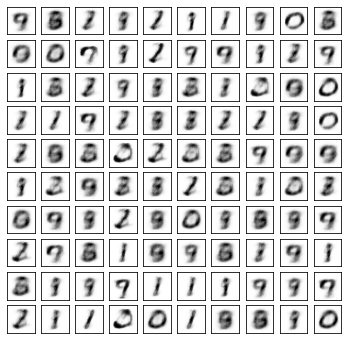

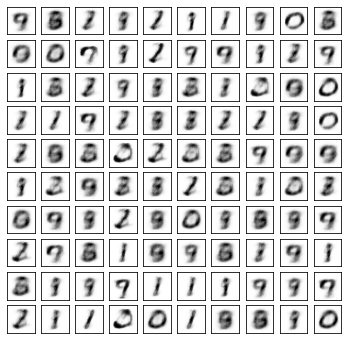

In [11]:
# Plot of Generated Images
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize= (6,6))
for i, j in itertools.product(range(size_figure_grid),range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

data_iter = iter(trainloader)
iter_per_epoch = len(trainloader)
total_step = 200
discriminatorloss= []
reconstructionloss= []
discriminatoraccuracy=[]

for step in range(total_step):

    runningloss_disc= 0
    runningloss_reco= 0
        
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(trainloader)

    images, labels = next(data_iter)
    images, labels = to_var(images.view(images.size(0), -1)), to_var(labels)
    
    P.zero_grad()
    Q.zero_grad()
    D_gauss.zero_grad()

    #Encoding to Latent space
    z_sample = Q(images)
    
    #Reconstruction of Image
    X_sample = P(z_sample)
    
    #Loss  
    
    z_real_gauss = to_var(torch.randn(images.size()[0], 2))
    D_real_gauss = D_gauss(z_real_gauss)

    z_fake_gauss = Q(images)
    D_fake_gauss = D_gauss(z_fake_gauss)
    
    D_loss = (-torch.mean(torch.log(D_real_gauss) + torch.log(1 - D_fake_gauss)))/2

    D_loss.backward()
    optim_D.step()
    discriminatorloss.append(D_loss) 
    
    
    recon_loss = F.binary_cross_entropy(X_sample,images)

    recon_loss.backward()
    optim_P.step()
    optim_Q_enc.step()

  
    Q.eval()
    


    # Generator
    Q.train()
    z_fake_gauss = Q(images)
    D_fake_gauss = D_gauss(z_fake_gauss)
    
    G_loss = -torch.mean(torch.log(D_fake_gauss))

    G_loss.backward()
    optim_Q_gen.step()
    
   
    P.eval()
    test_images = P(test_noise)
    P.train()
    
    #Encoding to Latent space
    z_sample = Q(images)
    
    #Reconstruction of Image
    X_sample = P(z_sample)
     
    decoder_loss = F.binary_cross_entropy(X_sample,images)
    reconstructionloss.append(decoder_loss)
    decoder_loss.backward()
    optim_P.step()
    optim_Q_enc.step()
    
    
            
    for k in range(num_test_samples):
        i = k//10
        j = k%10
        ax[i,j].cla()
        ax[i,j].imshow(to_np(test_images[k,:]).reshape(28, 28), cmap='Greys')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [12]:
import numpy as np
print(discriminatorloss)
a=np.asarray(discriminatorloss)
b=np.asarray(reconstructionloss)
c=1-b

[tensor(0.6790, grad_fn=<DivBackward0>), tensor(0.6913, grad_fn=<DivBackward0>), tensor(0.7007, grad_fn=<DivBackward0>), tensor(0.7048, grad_fn=<DivBackward0>), tensor(0.7330, grad_fn=<DivBackward0>), tensor(0.7601, grad_fn=<DivBackward0>), tensor(0.7789, grad_fn=<DivBackward0>), tensor(0.7618, grad_fn=<DivBackward0>), tensor(0.7216, grad_fn=<DivBackward0>), tensor(0.7082, grad_fn=<DivBackward0>), tensor(0.6951, grad_fn=<DivBackward0>), tensor(0.6802, grad_fn=<DivBackward0>), tensor(0.6830, grad_fn=<DivBackward0>), tensor(0.6671, grad_fn=<DivBackward0>), tensor(0.6794, grad_fn=<DivBackward0>), tensor(0.6785, grad_fn=<DivBackward0>), tensor(0.6837, grad_fn=<DivBackward0>), tensor(0.6814, grad_fn=<DivBackward0>), tensor(0.6803, grad_fn=<DivBackward0>), tensor(0.6764, grad_fn=<DivBackward0>), tensor(0.6825, grad_fn=<DivBackward0>), tensor(0.6801, grad_fn=<DivBackward0>), tensor(0.6753, grad_fn=<DivBackward0>), tensor(0.6771, grad_fn=<DivBackward0>), tensor(0.6771, grad_fn=<DivBackward0>),

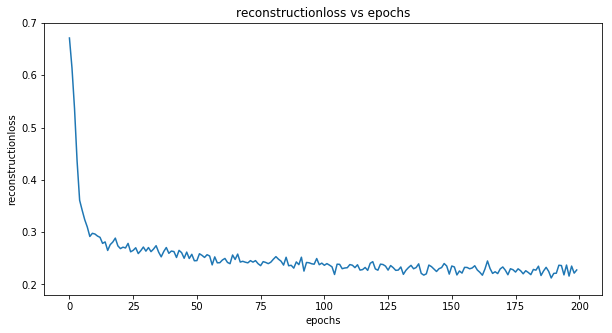

In [26]:
plt.figure(figsize=(10,5))
plt.ylim(0.18,.7)
plt.plot(b)
plt.title('reconstructionloss vs epochs')
plt.xlabel('epochs')
plt.ylabel('reconstructionloss')
plt.show()

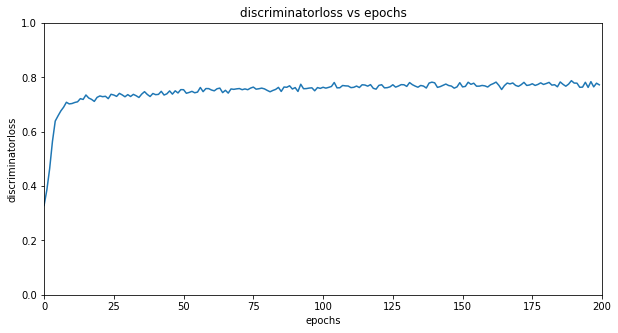

In [24]:
plt.figure(figsize=(10,5))
plt.ylim(0,1)
plt.xlim(0,200)
plt.plot(c)
plt.title('discriminatorloss vs epochs')
plt.xlabel('epochs')
plt.ylabel('discriminatorloss')
plt.show()

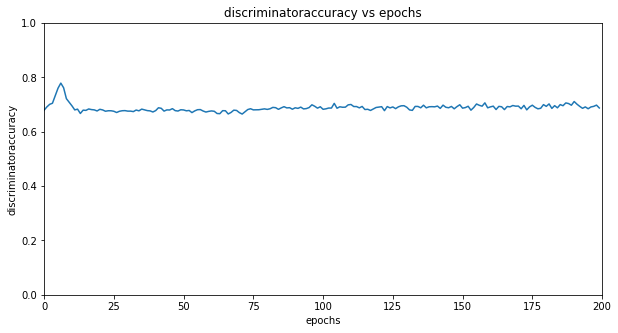

In [25]:
plt.figure(figsize=(10,5))
plt.ylim(0,1)
plt.xlim(0,200)
plt.plot(a)
plt.title('discriminatoraccuracy vs epochs')
plt.xlabel('epochs')
plt.ylabel('discriminatoraccuracy')
plt.show()